# USDA Food Desert definition 
(based on Characteristics and Influential Factors of Food Deserts)  

https://www.ers.usda.gov/publications/pub-details?pubid=45017

## A census tract is a food desert if it is both:
1. **Low-Income** (poverty ≥20% or median family income ≤80% of area median)
2. And **Low-Access** (≥500 people or ≥33% of residents live >1 mile (urban) or >10 miles (rural) from a supermarket).

File import:

- **Food Access Research Atlas**: A USDA dataset offering census tract–level insights on food access and food desert metrics across the U.S.
- **Historical SNAP Retailer Locator**: Historical locations and details of SNAP-authorized retailers.
- **ACS Poverty Data (2023)**: Census estimates on poverty from the ACS 5-year survey.
- **Geographic Correspondence (2022)**: Crosswalk information linking different geographic units.

### Files and packages import

In [1]:
import pandas as pd
import re
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
pd.set_option('display.max_columns', None)  # Ensure all columns are shown

atlas_path = 'https://drive.google.com/file/d/13Zdir2TlmEswVz-T5HmO2YG6cUWj2oYi/view?usp=share_link'
atlas_path='https://drive.usercontent.google.com/download?id={}&export=download&authuser=0&confirm=t'.format(atlas_path.split('/')[-2])

snap_path = 'https://drive.google.com/file/d/1okDqMsKm9CZrAChTfrQkG-jt2ab3M8gx/view?usp=share_link'
snap_path='https://drive.usercontent.google.com/download?id={}&export=download&authuser=0&confirm=t'.format(snap_path.split('/')[-2])

census_path = 'https://drive.google.com/file/d/1nUPrkN24BpjuzHW2PYvalVphrn-23sNZ/view?usp=share_link'
census_path='https://drive.usercontent.google.com/download?id={}&export=download&authuser=0&confirm=t'.format(census_path.split('/')[-2])

geocorr_path = 'https://drive.google.com/file/d/1JvUw1jvULzMQO7zvksFCCOV_Nmeel6xj/view?usp=share_link'
geocorr_path='https://drive.usercontent.google.com/download?id={}&export=download&authuser=0&confirm=t'.format(geocorr_path.split('/')[-2])

gaztract_path = 'https://drive.google.com/file/d/1DVtGxlrZQn3M7Rt0OYX3loGWYUdC1s90/view?usp=share_link'
gaztract_path='https://drive.usercontent.google.com/download?id={}&export=download&authuser=0&confirm=t'.format(gaztract_path.split('/')[-2])

url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_tract_500k.zip"

# atlas_path = 'assets/Food Access Research Atlas Data/Food Access Research Atlas.csv'
# snap_path = 'assets/SNAP/Historical SNAP Retailer Locator Data-20231231.csv'
# census_path = 'assets/CENSUS_Poverty/ACSST5Y2023.S1701-Data.csv'
# geocorr_path = 'assets/geocorr2022_2507800069.csv'
# gaztract_path = 'assets/2020_Gaz_tracts_national.txt'
# tiger_path = 'assets/Tiger/cb_2020_us_tract_500k.zip'
atlas = pd.read_csv(atlas_path)
snap = pd.read_csv(snap_path, dtype=str)
census = pd.read_csv(census_path, dtype=str, low_memory=False, skiprows=[1])
geocorr = pd.read_csv(geocorr_path, dtype=str, low_memory=False, skiprows=[1], encoding='ISO-8859-1')
Gaz_tracts = pd.read_csv(gaztract_path, delimiter='\t', dtype=str)
tiger_path = 'assets/Tiger/cb_2020_us_tract_500k.zip'
tracts_gdf = gpd.read_file(f"zip+{url}")                                       # census tract shapefile 

### Census df - GEOID_key extraction. Two step process  

GEOID is composed of 20 positions:  

    - Postions 1-9 identifies the type of geographical information, 1400000US means tact level
    - Position 10-11 identifies State as a fips code
    - Position 12-14 identifies County as a fips code
    - Position 1-20 provides the tract number  
    
It is standard to use the last 11 positions as joining key, however in census dataset there is approximately 28% of the rows do not have a standard GEOID, instead census identidied them as ZCTA (similar to ZIP codes but more consistent geographically speaking).

We first extracts tract when available. 

In [2]:
def get_tract(geoid):
    if not geoid.startswith('1400000US'):
        return None
    return geoid[-11:]

census['tract_lg'] = census['GEO_ID'].apply(get_tract)

census.sample(4)

,GEO_ID,NAME,S1701_C01_001E,S1701_C01_001M,S1701_C01_002E,S1701_C01_002M,S1701_C01_003E,S1701_C01_003M,S1701_C01_004E,S1701_C01_004M,S1701_C01_005E,S1701_C01_005M,S1701_C01_006E,S1701_C01_006M,S1701_C01_007E,S1701_C01_007M,S1701_C01_008E,S1701_C01_008M,S1701_C01_009E,S1701_C01_009M,S1701_C01_010E,S1701_C01_010M,S1701_C01_011E,S1701_C01_011M,S1701_C01_012E,S1701_C01_012M,S1701_C01_013E,S1701_C01_013M,S1701_C01_014E,S1701_C01_014M,S1701_C01_015E,S1701_C01_015M,S1701_C01_016E,S1701_C01_016M,S1701_C01_017E,S1701_C01_017M,S1701_C01_018E,S1701_C01_018M,S1701_C01_019E,S1701_C01_019M,S1701_C01_020E,S1701_C01_020M,S1701_C01_021E,S1701_C01_021M,S1701_C01_022E,S1701_C01_022M,S1701_C01_023E,S1701_C01_023M,S1701_C01_024E,S1701_C01_024M,S1701_C01_025E,S1701_C01_025M,S1701_C01_026E,S1701_C01_026M,S1701_C01_027E,S1701_C01_027M,S1701_C01_028E,S1701_C01_028M,S1701_C01_029E,S1701_C01_029M,S1701_C01_030E,S1701_C01_030M,S1701_C01_031E,S1701_C01_031M,S1701_C01_032E,S1701_C01_032M,S1701_C01_033E,S1701_C01_033M,S1701_C01_034E,S1701_C01_034M,S1701_C01_035E,S1701_C01_035M,S1701_C01_036E,S1701_C01_036M,S1701_C01_037E,S1701_C01_037M,S1701_C01_038E,S1701_C01_038M,S1701_C01_039E,S1701_C01_039M,S1701_C01_040E,S1701_C01_040M,S1701_C01_041E,S1701_C01_041M,S1701_C01_042E,S1701_C01_042M,S1701_C01_043E,S1701_C01_043M,S1701_C01_044E,S1701_C01_044M,S1701_C01_045E,S1701_C01_045M,S1701_C01_046E,S1701_C01_046M,S1701_C01_047E,S1701_C01_047M,S1701_C01_048E,S1701_C01_048M,S1701_C01_049E,S1701_C01_049M,S1701_C01_050E,S1701_C01_050M,S1701_C01_051E,S1701_C01_051M,S1701_C01_052E,S1701_C01_052M,S1701_C01_053E,S1701_C01_053M,S1701_C01_054E,S1701_C01_054M,S1701_C01_055E,S1701_C01_055M,S1701_C01_056E,S1701_C01_056M,S1701_C01_057E,S1701_C01_057M,S1701_C01_058E,S1701_C01_058M,S1701_C01_059E,S1701_C01_059M,S1701_C01_060E,S1701_C01_060M,S1701_C01_061E,S1701_C01_061M,S1701_C01_062E,S1701_C01_062M,S1701_C02_001E,S1701_C02_001M,S1701_C02_002E,S1701_C02_002M,S1701_C02_003E,S1701_C02_003M,S1701_C02_004E,S1701_C02_004M,S1701_C02_005E,S1701_C02_005M,S1701_C02_006E,S1701_C02_006M,S1701_C02_007E,S1701_C02_007M,S1701_C02_008E,S1701_C02_008M,S1701_C02_009E,S1701_C02_009M,S1701_C02_010E,S1701_C02_010M,S1701_C02_011E,S1701_C02_011M,S1701_C02_012E,S1701_C02_012M,S1701_C02_013E,S1701_C02_013M,S1701_C02_014E,S1701_C02_014M,S1701_C02_015E,S1701_C02_015M,S1701_C02_016E,S1701_C02_016M,S1701_C02_017E,S1701_C02_017M,S1701_C02_018E,S1701_C02_018M,S1701_C02_019E,S1701_C02_019M,S1701_C02_020E,S1701_C02_020M,S1701_C02_021E,S1701_C02_021M,S1701_C02_022E,S1701_C02_022M,S1701_C02_023E,S1701_C02_023M,S1701_C02_024E,S1701_C02_024M,S1701_C02_025E,S1701_C02_025M,S1701_C02_026E,S1701_C02_026M,S1701_C02_027E,S1701_C02_027M,S1701_C02_028E,S1701_C02_028M,S1701_C02_029E,S1701_C02_029M,S1701_C02_030E,S1701_C02_030M,S1701_C02_031E,S1701_C02_031M,S1701_C02_032E,S1701_C02_032M,S1701_C02_033E,S1701_C02_033M,S1701_C02_034E,S1701_C02_034M,S1701_C02_035E,S1701_C02_035M,S1701_C02_036E,S1701_C02_036M,S1701_C02_037E,S1701_C02_037M,S1701_C02_038E,S1701_C02_038M,S1701_C02_039E,S1701_C02_039M,S1701_C02_040E,S1701_C02_040M,S1701_C02_041E,S1701_C02_041M,S1701_C02_042E,S1701_C02_042M,S1701_C02_043E,S1701_C02_043M,S1701_C02_044E,S1701_C02_044M,S1701_C02_045E,S1701_C02_045M,S1701_C02_046E,S1701_C02_046M,S1701_C02_047E,S1701_C02_047M,S1701_C02_048E,S1701_C02_048M,S1701_C02_049E,S1701_C02_049M,S1701_C02_050E,S1701_C02_050M,S1701_C02_051E,S1701_C02_051M,S1701_C02_052E,S1701_C02_052M,S1701_C02_053E,S1701_C02_053M,S1701_C02_054E,S1701_C02_054M,S1701_C02_055E,S1701_C02_055M,S1701_C02_056E,S1701_C02_056M,S1701_C02_057E,S1701_C02_057M,S1701_C02_058E,S1701_C02_058M,S1701_C02_059E,S1701_C02_059M,S1701_C02_060E,S1701_C02_060M,S1701_C02_061E,S1701_C02_061M,S1701_C02_062E,S1701_C02_062M,S1701_C03_001E,S1701_C03_001M,S1701_C03_002E,S1701_C03_002M,S1701_C03_003E,S1701_C03_003M,S1701_C03_004E,S1701_C03_004M,S1701_C03_005E,S1701_C03_005M,S1701_C03_006E,S1701_C03_006M,S1701_C03_007E,S1701_C03_007M,S1701_C03_008E,S1701_C03_008M,S1701_C03_009E,S1701_C03_00

In [3]:
# proportion of missing standard GEOID values
census['tract_lg'].isna().mean() * 100

28.343390430790667

A second process needed extract zcta.Then it looks up ZCTA and bring tract from geocorr

### Cleaning df geocorr for key creation  

This sections creates a standard key GEOID to be used in census for rows with only zcta. The dictionary created is a lookup object

In [4]:
# clean and pad tract in geocorr then add county (State and county fips) to create GEOID
def transform_tract(tract_str):
    if pd.isna(tract_str):
        return tract_str
    if '.' in tract_str:
        # remove the decimal
        return tract_str.replace('.', '')
    else:
        # no decimal? then add '00' at the end
        return tract_str + '00'
   
geocorr['tract_only'] = geocorr['tract'].apply(transform_tract)
geocorr['tract_only'] = geocorr['tract_only'].astype(str).str.zfill(6)   # standardize it 6 digit position
geocorr['county'] = geocorr['county'].astype(str).str.zfill(5)
geocorr['GEOID'] = geocorr['county'] + geocorr['tract_only']
geocorr.drop(columns=['Unnamed: 6'], inplace=True)
geocorr['zcta'] = geocorr['zcta'].astype(str)
zcta_to_geoid = dict(zip(geocorr['zcta'], geocorr['GEOID'].astype(str))) # dict for mapping zcta to GEOID 
geocorr.sample(4)

,county,tract,zcta,CountyName,ZIPName,pop20,tract_only,GEOID
106992,37151,313.03,27263,Randolph NC,"High Point, NC",454,031303,37151031303
71816,26105,9501,49660,Mason MI,"Manistee, MI",97,950100,26105950100
137415,48061,144.02,78526,Cameron TX,"Brownsville, TX",6606,014402,48061014402
38382,13151,701.28,30294,Henry GA,"Ellenwood, GA",1484,070128,13151070128


### Create Key for census   

For the cases where only zcta is provided, geocorr is used to add GEOID key

In [5]:
def extract_zcta(name_string):
    match = re.search(r'ZCTA5\s+(\d+)', name_string)
    if match:
        return match.group(1)
    return None
only_zcta = census['tract_lg'].isna()                                                          # mask for only zcta
census.loc[only_zcta, 'extracted_zcta'] = census.loc[only_zcta, 'NAME'].apply(extract_zcta)    # [ZCTA] from NAME only for rows that have zcta
census.loc[only_zcta, 'GEOID_geocorr'] = census.loc[only_zcta, 'extracted_zcta'].map(zcta_to_geoid) # fill missing Tract values using the extracted ZCTA
census['GEOID_Key'] = census['tract_lg'].fillna(census['GEOID_geocorr'])                       # mege both fields to create final key
census.drop(columns=['Unnamed: 374','tract_lg','GEOID_geocorr'], inplace=True)   
census.sample(4)

,GEO_ID,NAME,S1701_C01_001E,S1701_C01_001M,S1701_C01_002E,S1701_C01_002M,S1701_C01_003E,S1701_C01_003M,S1701_C01_004E,S1701_C01_004M,S1701_C01_005E,S1701_C01_005M,S1701_C01_006E,S1701_C01_006M,S1701_C01_007E,S1701_C01_007M,S1701_C01_008E,S1701_C01_008M,S1701_C01_009E,S1701_C01_009M,S1701_C01_010E,S1701_C01_010M,S1701_C01_011E,S1701_C01_011M,S1701_C01_012E,S1701_C01_012M,S1701_C01_013E,S1701_C01_013M,S1701_C01_014E,S1701_C01_014M,S1701_C01_015E,S1701_C01_015M,S1701_C01_016E,S1701_C01_016M,S1701_C01_017E,S1701_C01_017M,S1701_C01_018E,S1701_C01_018M,S1701_C01_019E,S1701_C01_019M,S1701_C01_020E,S1701_C01_020M,S1701_C01_021E,S1701_C01_021M,S1701_C01_022E,S1701_C01_022M,S1701_C01_023E,S1701_C01_023M,S1701_C01_024E,S1701_C01_024M,S1701_C01_025E,S1701_C01_025M,S1701_C01_026E,S1701_C01_026M,S1701_C01_027E,S1701_C01_027M,S1701_C01_028E,S1701_C01_028M,S1701_C01_029E,S1701_C01_029M,S1701_C01_030E,S1701_C01_030M,S1701_C01_031E,S1701_C01_031M,S1701_C01_032E,S1701_C01_032M,S1701_C01_033E,S1701_C01_033M,S1701_C01_034E,S1701_C01_034M,S1701_C01_035E,S1701_C01_035M,S1701_C01_036E,S1701_C01_036M,S1701_C01_037E,S1701_C01_037M,S1701_C01_038E,S1701_C01_038M,S1701_C01_039E,S1701_C01_039M,S1701_C01_040E,S1701_C01_040M,S1701_C01_041E,S1701_C01_041M,S1701_C01_042E,S1701_C01_042M,S1701_C01_043E,S1701_C01_043M,S1701_C01_044E,S1701_C01_044M,S1701_C01_045E,S1701_C01_045M,S1701_C01_046E,S1701_C01_046M,S1701_C01_047E,S1701_C01_047M,S1701_C01_048E,S1701_C01_048M,S1701_C01_049E,S1701_C01_049M,S1701_C01_050E,S1701_C01_050M,S1701_C01_051E,S1701_C01_051M,S1701_C01_052E,S1701_C01_052M,S1701_C01_053E,S1701_C01_053M,S1701_C01_054E,S1701_C01_054M,S1701_C01_055E,S1701_C01_055M,S1701_C01_056E,S1701_C01_056M,S1701_C01_057E,S1701_C01_057M,S1701_C01_058E,S1701_C01_058M,S1701_C01_059E,S1701_C01_059M,S1701_C01_060E,S1701_C01_060M,S1701_C01_061E,S1701_C01_061M,S1701_C01_062E,S1701_C01_062M,S1701_C02_001E,S1701_C02_001M,S1701_C02_002E,S1701_C02_002M,S1701_C02_003E,S1701_C02_003M,S1701_C02_004E,S1701_C02_004M,S1701_C02_005E,S1701_C02_005M,S1701_C02_006E,S1701_C02_006M,S1701_C02_007E,S1701_C02_007M,S1701_C02_008E,S1701_C02_008M,S1701_C02_009E,S1701_C02_009M,S1701_C02_010E,S1701_C02_010M,S1701_C02_011E,S1701_C02_011M,S1701_C02_012E,S1701_C02_012M,S1701_C02_013E,S1701_C02_013M,S1701_C02_014E,S1701_C02_014M,S1701_C02_015E,S1701_C02_015M,S1701_C02_016E,S1701_C02_016M,S1701_C02_017E,S1701_C02_017M,S1701_C02_018E,S1701_C02_018M,S1701_C02_019E,S1701_C02_019M,S1701_C02_020E,S1701_C02_020M,S1701_C02_021E,S1701_C02_021M,S1701_C02_022E,S1701_C02_022M,S1701_C02_023E,S1701_C02_023M,S1701_C02_024E,S1701_C02_024M,S1701_C02_025E,S1701_C02_025M,S1701_C02_026E,S1701_C02_026M,S1701_C02_027E,S1701_C02_027M,S1701_C02_028E,S1701_C02_028M,S1701_C02_029E,S1701_C02_029M,S1701_C02_030E,S1701_C02_030M,S1701_C02_031E,S1701_C02_031M,S1701_C02_032E,S1701_C02_032M,S1701_C02_033E,S1701_C02_033M,S1701_C02_034E,S1701_C02_034M,S1701_C02_035E,S1701_C02_035M,S1701_C02_036E,S1701_C02_036M,S1701_C02_037E,S1701_C02_037M,S1701_C02_038E,S1701_C02_038M,S1701_C02_039E,S1701_C02_039M,S1701_C02_040E,S1701_C02_040M,S1701_C02_041E,S1701_C02_041M,S1701_C02_042E,S1701_C02_042M,S1701_C02_043E,S1701_C02_043M,S1701_C02_044E,S1701_C02_044M,S1701_C02_045E,S1701_C02_045M,S1701_C02_046E,S1701_C02_046M,S1701_C02_047E,S1701_C02_047M,S1701_C02_048E,S1701_C02_048M,S1701_C02_049E,S1701_C02_049M,S1701_C02_050E,S1701_C02_050M,S1701_C02_051E,S1701_C02_051M,S1701_C02_052E,S1701_C02_052M,S1701_C02_053E,S1701_C02_053M,S1701_C02_054E,S1701_C02_054M,S1701_C02_055E,S1701_C02_055M,S1701_C02_056E,S1701_C02_056M,S1701_C02_057E,S1701_C02_057M,S1701_C02_058E,S1701_C02_058M,S1701_C02_059E,S1701_C02_059M,S1701_C02_060E,S1701_C02_060M,S1701_C02_061E,S1701_C02_061M,S1701_C02_062E,S1701_C02_062M,S1701_C03_001E,S1701_C03_001M,S1701_C03_002E,S1701_C03_002M,S1701_C03_003E,S1701_C03_003M,S1701_C03_004E,S1701_C03_004M,S1701_C03_005E,S1701_C03_005M,S1701_C03_006E,S1701_C03_006M,S1701_C03_007E,S1701_C03_007M,S1701_C03_008E,S1701_C03_008M,S1701_C03_009E,S1701_C03_00

Merging census and atlas by common standardized key GEOCODEID_key

In [6]:
atlas['GEOID_Key'] = atlas['CensusTract'].astype(str).str.zfill(11)
atlas_census = pd.merge(atlas, census, how='left', on='GEOID_Key')

In [7]:
atlas_census.sample(4)

,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,PovertyRate,MedianFamilyIncome,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lapophalfshare,lalowihalf,lalowihalfshare,lakidshalf,lakidshalfshare,laseniorshalf,laseniorshalfshare,lawhitehalf,lawhitehalfshare,lablackhalf,lablackhalfshare,laasianhalf,laasianhalfshare,lanhopihalf,lanhopihalfshare,laaianhalf,laaianhalfshare,laomultirhalf,laomultirhalfshare,lahisphalf,lahisphalfshare,lahunvhalf,lahunvhalfshare,lasnaphalf,lasnaphalfshare,lapop1,lapop1share,lalowi1,lalowi1share,lakids1,lakids1share,laseniors1,laseniors1share,lawhite1,lawhite1share,lablack1,lablack1share,laasian1,laasian1share,lanhopi1,lanhopi1share,laaian1,laaian1share,laomultir1,laomultir1share,lahisp1,lahisp1share,lahunv1,lahunv1share,lasnap1,lasnap1share,lapop10,lapop10share,lalowi10,lalowi10share,lakids10,lakids10share,laseniors10,laseniors10share,lawhite10,lawhite10share,lablack10,lablack10share,laasian10,laasian10share,lanhopi10,lanhopi10share,laaian10,laaian10share,laomultir10,laomultir10share,lahisp10,lahisp10share,lahunv10,lahunv10share,lasnap10,lasnap10share,lapop20,lapop20share,lalowi20,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lawhite20,lawhite20share,lablack20,lablack20share,laasian20,laasian20share,lanhopi20,lanhopi20share,laaian20,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,GEOID_Key,GEO_ID,NAME,S1701_C01_001E,S1701_C01_001M,S1701_C01_002E,S1701_C01_002M,S1701_C01_003E,S1701_C01_003M,S1701_C01_004E,S1701_C01_004M,S1701_C01_005E,S1701_C01_005M,S1701_C01_006E,S1701_C01_006M,S1701_C01_007E,S1701_C01_007M,S1701_C01_008E,S1701_C01_008M,S1701_C01_009E,S1701_C01_009M,S1701_C01_010E,S1701_C01_010M,S1701_C01_011E,S1701_C01_011M,S1701_C01_012E,S1701_C01_012M,S1701_C01_013E,S1701_C01_013M,S1701_C01_014E,S1701_C01_014M,S1701_C01_015E,S1701_C01_015M,S1701_C01_016E,S1701_C01_016M,S1701_C01_017E,S1701_C01_017M,S1701_C01_018E,S1701_C01_018M,S1701_C01_019E,S1701_C01_019M,S1701_C01_020E,S1701_C01_020M,S1701_C01_021E,S1701_C01_021M,S1701_C01_022E,S1701_C01_022M,S1701_C01_023E,S1701_C01_023M,S1701_C01_024E,S1701_C01_024M,S1701_C01_025E,S1701_C01_025M,S1701_C01_026E,S1701_C01_026M,S1701_C01_027E,S1701_C01_027M,S1701_C01_028E,S1701_C01_028M,S1701_C01_029E,S1701_C01_029M,S1701_C01_030E,S1701_C01_030M,S1701_C01_031E,S1701_C01_031M,S1701_C01_032E,S1701_C01_032M,S1701_C01_033E,S1701_C01_033M,S1701_C01_034E,S1701_C01_034M,S1701_C01_035E,S1701_C01_035M,S1701_C01_036E,S1701_C01_036M,S1701_C01_037E,S1701_C01_037M,S1701_C01_038E,S1701_C01_038M,S1701_C01_039E,S1701_C01_039M,S1701_C01_040E,S1701_C01_040M,S1701_C01_041E,S1701_C01_041M,S1701_C01_042E,S1701_C01_042M,S1701_C01_043E,S1701_C01_043M,S1701_C01_044E,S1701_C01_044M,S1701_C01_045E,S1701_C01_045M,S1701_C01_046E,S1701_C01_046M,S1701_C01_047E,S1701_C01_047M,S1701_C01_048E,S1701_C01_048M,S1701_C01_049E,S1701_C01_049M,S1701_C01_050E,S1701_C01_050M,S1701_C01_051E,S1701_C01_051M,S1701_C01_052E,S1701_C01_052M,S1701_C01_053E,S1701_C01_053M,S1701_C01_054E,S1701_C01_054M,S1701_C01_055E,S1701_C01_055M,S1701_C01_056E,S1701_C01_056M,S1701_C01_057E,S1701_C01_057M,S1701_C01_058E,S1701_C01_058M,S1701_C01_059E,S1701_C01_059M,S1701_C01_060E,S1701_C01_060M,S1701_C01_061E,S1701_C01_061M,S1701_C01_062E,S1701_C01_062M,S1701_C02_001E,S1701_C02_001M,S1701_C02_002E,S1701_C02_002M,S1701_C02_003E,S1701_C02_003M,S1701_C02_004E,S1701_C02_004M,S1701_C02_005E,S1701_C02_005M,S1701_C02_006E,S1701_C02_006M,S1701_C02_007E,S1701_C02_007M,S1701_C02_008E,S1701_C02_008M,S1701_C02_009E,S1701_C02_009M,S1701_C02_010E,S1701_C02_010M,S1701_C02_011E

In [8]:
atlas_census['GEO_ID'].isna().sum()

12190

### State and Region   

This section maps the datasets to their State and region

In [9]:
state_mapppings= {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
    'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
    'WI': 'Wisconsin', 'WY': 'Wyoming','PR': 'Puerto Rico'}

geocorr['StateName'] = geocorr['CountyName'].str[-2:].map(state_mapppings)           # needed to map zcta cases in census


Need to create State in census in order to map it to the region. Two process needed as variable NAME in census is not consistent. Sometimes it carries values like "Census Tract 205.01; Autauga County; Alabama" and sometimes velues like "ZCTA5 99923". So two separate processes are needed to obtain State first

In [10]:
# first process: wextract state from long description like:'Census Tract 204; Autauga County; Alabama'
def extract_state(name):
    parts = name.split(';')
    if len(parts) > 1:
        return parts[-1].strip()
    return None

# apply the function to create the State column for rows with long descriptions
census['State'] = census['NAME'].apply(extract_state)

# ADITIONAL PROCESS NEEDED for rows with ZCTAs only (short descriptions). 
# rows where extracted_zcta is not NaN and State hasn't been set
zcta_to_state = dict(zip(geocorr['zcta'], geocorr['StateName']))                       # mapping. zcta to StateName 

# use the mapping to fill in the State
zcta_only = census['State'].isnull() & census['extracted_zcta'].notnull()
census.loc[zcta_only, 'State'] = census.loc[zcta_only, 'extracted_zcta'].map(zcta_to_state)


### Adding Region to Census and Atlas now that State is available

In [11]:
regions = {
    'Northeast': ['Connecticut', 'Delaware', 'Maine', 'Maryland', 'Massachusetts', 'New Hampshire', 'New Jersey', 'New York', 'Pennsylvania', 'Rhode Island', 'Vermont'],
    'Southeast': ['Alabama', 'Arkansas', 'Florida', 'Georgia', 'Kentucky', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee', 'Virginia', 'West Virginia'],
    'Midwest': ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin'],
    'Southwest': ['Arizona', 'New Mexico', 'Oklahoma', 'Texas'],
    'West': ['Alaska', 'California', 'Colorado', 'Hawaii', 'Idaho', 'Montana', 'Nevada', 'Oregon', 'Utah', 'Washington', 'Wyoming']}
selected_states = ['Texas']
selected_region = ['Southeast']

def get_region(state):
    for region, states in regions.items():
        if state in states:
            return region
    return 'Unknown'
def get_selected_states(state):
    return 1 if state in selected_states else 0
def get_selected_region(region):
    return 1 if region in selected_region else 0
    
atlas['region'] = atlas['State'].apply(get_region)
atlas['selected_region'] = atlas['region'].apply(get_selected_region)
atlas['selected_states'] = atlas['State'].apply(get_selected_states)

census['region'] = census['State'].apply(get_region)
census['selected_states'] = census['State'].apply(get_selected_states)
census['selected_region'] = census['region'].apply(get_selected_region)

atlas_census['region'] = atlas_census['State'].apply(get_region)
atlas_census['selected_states'] = atlas_census['State'].apply(get_selected_states)
atlas_census['selected_region'] = atlas_census['region'].apply(get_selected_region)

Option 1. Definition Replication based on Atlas df only. Also use other fields in addition to LILATracts_1And10

In [12]:
# POVERTY: low income
atlas_census['low_income_flag'] = atlas_census['LowIncomeTracts']
# low access mean (33% of the population) or absolute count (at least 500 residents) living beyond the respective distance thresholds.
atlas_census['low_access_flag'] = (
    ((atlas_census['LAPOP1_10'] >= 500) | ((atlas_census['LAPOP1_10'] / atlas_census['Pop2010']) >= 0.33))
    .astype(int))
atlas_census['food_desert_flag'] = atlas_census['low_income_flag'] & atlas_census['low_access_flag']
atlas_census['USDA_flag']=atlas_census['LILATracts_1And10']


In [13]:
atlas_census.sample(4)

,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,PovertyRate,MedianFamilyIncome,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lapophalfshare,lalowihalf,lalowihalfshare,lakidshalf,lakidshalfshare,laseniorshalf,laseniorshalfshare,lawhitehalf,lawhitehalfshare,lablackhalf,lablackhalfshare,laasianhalf,laasianhalfshare,lanhopihalf,lanhopihalfshare,laaianhalf,laaianhalfshare,laomultirhalf,laomultirhalfshare,lahisphalf,lahisphalfshare,lahunvhalf,lahunvhalfshare,lasnaphalf,lasnaphalfshare,lapop1,lapop1share,lalowi1,lalowi1share,lakids1,lakids1share,laseniors1,laseniors1share,lawhite1,lawhite1share,lablack1,lablack1share,laasian1,laasian1share,lanhopi1,lanhopi1share,laaian1,laaian1share,laomultir1,laomultir1share,lahisp1,lahisp1share,lahunv1,lahunv1share,lasnap1,lasnap1share,lapop10,lapop10share,lalowi10,lalowi10share,lakids10,lakids10share,laseniors10,laseniors10share,lawhite10,lawhite10share,lablack10,lablack10share,laasian10,laasian10share,lanhopi10,lanhopi10share,laaian10,laaian10share,laomultir10,laomultir10share,lahisp10,lahisp10share,lahunv10,lahunv10share,lasnap10,lasnap10share,lapop20,lapop20share,lalowi20,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lawhite20,lawhite20share,lablack20,lablack20share,laasian20,laasian20share,lanhopi20,lanhopi20share,laaian20,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,GEOID_Key,GEO_ID,NAME,S1701_C01_001E,S1701_C01_001M,S1701_C01_002E,S1701_C01_002M,S1701_C01_003E,S1701_C01_003M,S1701_C01_004E,S1701_C01_004M,S1701_C01_005E,S1701_C01_005M,S1701_C01_006E,S1701_C01_006M,S1701_C01_007E,S1701_C01_007M,S1701_C01_008E,S1701_C01_008M,S1701_C01_009E,S1701_C01_009M,S1701_C01_010E,S1701_C01_010M,S1701_C01_011E,S1701_C01_011M,S1701_C01_012E,S1701_C01_012M,S1701_C01_013E,S1701_C01_013M,S1701_C01_014E,S1701_C01_014M,S1701_C01_015E,S1701_C01_015M,S1701_C01_016E,S1701_C01_016M,S1701_C01_017E,S1701_C01_017M,S1701_C01_018E,S1701_C01_018M,S1701_C01_019E,S1701_C01_019M,S1701_C01_020E,S1701_C01_020M,S1701_C01_021E,S1701_C01_021M,S1701_C01_022E,S1701_C01_022M,S1701_C01_023E,S1701_C01_023M,S1701_C01_024E,S1701_C01_024M,S1701_C01_025E,S1701_C01_025M,S1701_C01_026E,S1701_C01_026M,S1701_C01_027E,S1701_C01_027M,S1701_C01_028E,S1701_C01_028M,S1701_C01_029E,S1701_C01_029M,S1701_C01_030E,S1701_C01_030M,S1701_C01_031E,S1701_C01_031M,S1701_C01_032E,S1701_C01_032M,S1701_C01_033E,S1701_C01_033M,S1701_C01_034E,S1701_C01_034M,S1701_C01_035E,S1701_C01_035M,S1701_C01_036E,S1701_C01_036M,S1701_C01_037E,S1701_C01_037M,S1701_C01_038E,S1701_C01_038M,S1701_C01_039E,S1701_C01_039M,S1701_C01_040E,S1701_C01_040M,S1701_C01_041E,S1701_C01_041M,S1701_C01_042E,S1701_C01_042M,S1701_C01_043E,S1701_C01_043M,S1701_C01_044E,S1701_C01_044M,S1701_C01_045E,S1701_C01_045M,S1701_C01_046E,S1701_C01_046M,S1701_C01_047E,S1701_C01_047M,S1701_C01_048E,S1701_C01_048M,S1701_C01_049E,S1701_C01_049M,S1701_C01_050E,S1701_C01_050M,S1701_C01_051E,S1701_C01_051M,S1701_C01_052E,S1701_C01_052M,S1701_C01_053E,S1701_C01_053M,S1701_C01_054E,S1701_C01_054M,S1701_C01_055E,S1701_C01_055M,S1701_C01_056E,S1701_C01_056M,S1701_C01_057E,S1701_C01_057M,S1701_C01_058E,S1701_C01_058M,S1701_C01_059E,S1701_C01_059M,S1701_C01_060E,S1701_C01_060M,S1701_C01_061E,S1701_C01_061M,S1701_C01_062E,S1701_C01_062M,S1701_C02_001E,S1701_C02_001M,S1701_C02_002E,S1701_C02_002M,S1701_C02_003E,S1701_C02_003M,S1701_C02_004E,S1701_C02_004M,S1701_C02_005E,S1701_C02_005M,S1701_C02_006E,S1701_C02_006M,S1701_C02_007E,S1701_C02_007M,S1701_C02_008E,S1701_C02_008M,S1701_C02_009E,S1701_C02_009M,S1701_C02_010E,S1701_C02_010M,S1701_C02_011E

Option 2. Using Census & SNAP

We first estimate poverty rate to determine whether it is above 20% level

In [14]:
atlas_census['S1701_C02_001E'] = pd.to_numeric(atlas_census['S1701_C02_001E'])
atlas_census['S1701_C01_001E'] = pd.to_numeric(atlas_census['S1701_C01_001E'])
atlas_census['poverty_rate_calc'] = (atlas_census['S1701_C02_001E'] / atlas_census['S1701_C01_001E'] * 100)
atlas_census['low_income_flag'] = (atlas_census['poverty_rate_calc'] >= 20).astype(int)

atlas_census.sample(4)

,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,PovertyRate,MedianFamilyIncome,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lapophalfshare,lalowihalf,lalowihalfshare,lakidshalf,lakidshalfshare,laseniorshalf,laseniorshalfshare,lawhitehalf,lawhitehalfshare,lablackhalf,lablackhalfshare,laasianhalf,laasianhalfshare,lanhopihalf,lanhopihalfshare,laaianhalf,laaianhalfshare,laomultirhalf,laomultirhalfshare,lahisphalf,lahisphalfshare,lahunvhalf,lahunvhalfshare,lasnaphalf,lasnaphalfshare,lapop1,lapop1share,lalowi1,lalowi1share,lakids1,lakids1share,laseniors1,laseniors1share,lawhite1,lawhite1share,lablack1,lablack1share,laasian1,laasian1share,lanhopi1,lanhopi1share,laaian1,laaian1share,laomultir1,laomultir1share,lahisp1,lahisp1share,lahunv1,lahunv1share,lasnap1,lasnap1share,lapop10,lapop10share,lalowi10,lalowi10share,lakids10,lakids10share,laseniors10,laseniors10share,lawhite10,lawhite10share,lablack10,lablack10share,laasian10,laasian10share,lanhopi10,lanhopi10share,laaian10,laaian10share,laomultir10,laomultir10share,lahisp10,lahisp10share,lahunv10,lahunv10share,lasnap10,lasnap10share,lapop20,lapop20share,lalowi20,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lawhite20,lawhite20share,lablack20,lablack20share,laasian20,laasian20share,lanhopi20,lanhopi20share,laaian20,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,GEOID_Key,GEO_ID,NAME,S1701_C01_001E,S1701_C01_001M,S1701_C01_002E,S1701_C01_002M,S1701_C01_003E,S1701_C01_003M,S1701_C01_004E,S1701_C01_004M,S1701_C01_005E,S1701_C01_005M,S1701_C01_006E,S1701_C01_006M,S1701_C01_007E,S1701_C01_007M,S1701_C01_008E,S1701_C01_008M,S1701_C01_009E,S1701_C01_009M,S1701_C01_010E,S1701_C01_010M,S1701_C01_011E,S1701_C01_011M,S1701_C01_012E,S1701_C01_012M,S1701_C01_013E,S1701_C01_013M,S1701_C01_014E,S1701_C01_014M,S1701_C01_015E,S1701_C01_015M,S1701_C01_016E,S1701_C01_016M,S1701_C01_017E,S1701_C01_017M,S1701_C01_018E,S1701_C01_018M,S1701_C01_019E,S1701_C01_019M,S1701_C01_020E,S1701_C01_020M,S1701_C01_021E,S1701_C01_021M,S1701_C01_022E,S1701_C01_022M,S1701_C01_023E,S1701_C01_023M,S1701_C01_024E,S1701_C01_024M,S1701_C01_025E,S1701_C01_025M,S1701_C01_026E,S1701_C01_026M,S1701_C01_027E,S1701_C01_027M,S1701_C01_028E,S1701_C01_028M,S1701_C01_029E,S1701_C01_029M,S1701_C01_030E,S1701_C01_030M,S1701_C01_031E,S1701_C01_031M,S1701_C01_032E,S1701_C01_032M,S1701_C01_033E,S1701_C01_033M,S1701_C01_034E,S1701_C01_034M,S1701_C01_035E,S1701_C01_035M,S1701_C01_036E,S1701_C01_036M,S1701_C01_037E,S1701_C01_037M,S1701_C01_038E,S1701_C01_038M,S1701_C01_039E,S1701_C01_039M,S1701_C01_040E,S1701_C01_040M,S1701_C01_041E,S1701_C01_041M,S1701_C01_042E,S1701_C01_042M,S1701_C01_043E,S1701_C01_043M,S1701_C01_044E,S1701_C01_044M,S1701_C01_045E,S1701_C01_045M,S1701_C01_046E,S1701_C01_046M,S1701_C01_047E,S1701_C01_047M,S1701_C01_048E,S1701_C01_048M,S1701_C01_049E,S1701_C01_049M,S1701_C01_050E,S1701_C01_050M,S1701_C01_051E,S1701_C01_051M,S1701_C01_052E,S1701_C01_052M,S1701_C01_053E,S1701_C01_053M,S1701_C01_054E,S1701_C01_054M,S1701_C01_055E,S1701_C01_055M,S1701_C01_056E,S1701_C01_056M,S1701_C01_057E,S1701_C01_057M,S1701_C01_058E,S1701_C01_058M,S1701_C01_059E,S1701_C01_059M,S1701_C01_060E,S1701_C01_060M,S1701_C01_061E,S1701_C01_061M,S1701_C01_062E,S1701_C01_062M,S1701_C02_001E,S1701_C02_001M,S1701_C02_002E,S1701_C02_002M,S1701_C02_003E,S1701_C02_003M,S1701_C02_004E,S1701_C02_004M,S1701_C02_005E,S1701_C02_005M,S1701_C02_006E,S1701_C02_006M,S1701_C02_007E,S1701_C02_007M,S1701_C02_008E,S1701_C02_008M,S1701_C02_009E,S1701_C02_009M,S1701_C02_010E,S1701_C02_010M,S1701_C02_011E

In [15]:
########################### TO FILTER REGION OR STATE ###########################
# filter the dataframe to include only rows for the selected region or States
filtered_atlas_census = atlas_census[atlas_census['selected_states'] == 1]
#filtered_atlas_census = atlas_census[atlas_census['selected_region'] == 1]

# check % of agreement between definitions in Atlas only (both 1 or both 0)
agreement = filtered_atlas_census['food_desert_flag'] == filtered_atlas_census['USDA_flag']

print('Agreement Percentage for selected_region==1 ',  agreement.mean() * 100,'%')


Agreement Percentage for selected_region==1  100.0 %


In [16]:
filtered_atlas_census['food_desert_flag'].isna().sum()

0

In [17]:
#Gaz_tracts['GEOID'] = Gaz_tracts['GEOID'].astype(str).str.zfill(11)
Gaz_tracts = Gaz_tracts.drop(columns=['USPS', 'ALAND', 'AWATER', 'ALAND_SQMI', 'AWATER_SQMI'], errors='ignore')
atlas_census_loc = pd.merge(filtered_atlas_census, Gaz_tracts, how='left', left_on='GEOID_Key', right_on='GEOID')
print (len(atlas_census_loc))
print (atlas_census_loc['poverty_rate_calc'].isna().sum())
atlas_census_loc.sample(4)

6553
1545


,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,PovertyRate,MedianFamilyIncome,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lapophalfshare,lalowihalf,lalowihalfshare,lakidshalf,lakidshalfshare,laseniorshalf,laseniorshalfshare,lawhitehalf,lawhitehalfshare,lablackhalf,lablackhalfshare,laasianhalf,laasianhalfshare,lanhopihalf,lanhopihalfshare,laaianhalf,laaianhalfshare,laomultirhalf,laomultirhalfshare,lahisphalf,lahisphalfshare,lahunvhalf,lahunvhalfshare,lasnaphalf,lasnaphalfshare,lapop1,lapop1share,lalowi1,lalowi1share,lakids1,lakids1share,laseniors1,laseniors1share,lawhite1,lawhite1share,lablack1,lablack1share,laasian1,laasian1share,lanhopi1,lanhopi1share,laaian1,laaian1share,laomultir1,laomultir1share,lahisp1,lahisp1share,lahunv1,lahunv1share,lasnap1,lasnap1share,lapop10,lapop10share,lalowi10,lalowi10share,lakids10,lakids10share,laseniors10,laseniors10share,lawhite10,lawhite10share,lablack10,lablack10share,laasian10,laasian10share,lanhopi10,lanhopi10share,laaian10,laaian10share,laomultir10,laomultir10share,lahisp10,lahisp10share,lahunv10,lahunv10share,lasnap10,lasnap10share,lapop20,lapop20share,lalowi20,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lawhite20,lawhite20share,lablack20,lablack20share,laasian20,laasian20share,lanhopi20,lanhopi20share,laaian20,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,GEOID_Key,GEO_ID,NAME,S1701_C01_001E,S1701_C01_001M,S1701_C01_002E,S1701_C01_002M,S1701_C01_003E,S1701_C01_003M,S1701_C01_004E,S1701_C01_004M,S1701_C01_005E,S1701_C01_005M,S1701_C01_006E,S1701_C01_006M,S1701_C01_007E,S1701_C01_007M,S1701_C01_008E,S1701_C01_008M,S1701_C01_009E,S1701_C01_009M,S1701_C01_010E,S1701_C01_010M,S1701_C01_011E,S1701_C01_011M,S1701_C01_012E,S1701_C01_012M,S1701_C01_013E,S1701_C01_013M,S1701_C01_014E,S1701_C01_014M,S1701_C01_015E,S1701_C01_015M,S1701_C01_016E,S1701_C01_016M,S1701_C01_017E,S1701_C01_017M,S1701_C01_018E,S1701_C01_018M,S1701_C01_019E,S1701_C01_019M,S1701_C01_020E,S1701_C01_020M,S1701_C01_021E,S1701_C01_021M,S1701_C01_022E,S1701_C01_022M,S1701_C01_023E,S1701_C01_023M,S1701_C01_024E,S1701_C01_024M,S1701_C01_025E,S1701_C01_025M,S1701_C01_026E,S1701_C01_026M,S1701_C01_027E,S1701_C01_027M,S1701_C01_028E,S1701_C01_028M,S1701_C01_029E,S1701_C01_029M,S1701_C01_030E,S1701_C01_030M,S1701_C01_031E,S1701_C01_031M,S1701_C01_032E,S1701_C01_032M,S1701_C01_033E,S1701_C01_033M,S1701_C01_034E,S1701_C01_034M,S1701_C01_035E,S1701_C01_035M,S1701_C01_036E,S1701_C01_036M,S1701_C01_037E,S1701_C01_037M,S1701_C01_038E,S1701_C01_038M,S1701_C01_039E,S1701_C01_039M,S1701_C01_040E,S1701_C01_040M,S1701_C01_041E,S1701_C01_041M,S1701_C01_042E,S1701_C01_042M,S1701_C01_043E,S1701_C01_043M,S1701_C01_044E,S1701_C01_044M,S1701_C01_045E,S1701_C01_045M,S1701_C01_046E,S1701_C01_046M,S1701_C01_047E,S1701_C01_047M,S1701_C01_048E,S1701_C01_048M,S1701_C01_049E,S1701_C01_049M,S1701_C01_050E,S1701_C01_050M,S1701_C01_051E,S1701_C01_051M,S1701_C01_052E,S1701_C01_052M,S1701_C01_053E,S1701_C01_053M,S1701_C01_054E,S1701_C01_054M,S1701_C01_055E,S1701_C01_055M,S1701_C01_056E,S1701_C01_056M,S1701_C01_057E,S1701_C01_057M,S1701_C01_058E,S1701_C01_058M,S1701_C01_059E,S1701_C01_059M,S1701_C01_060E,S1701_C01_060M,S1701_C01_061E,S1701_C01_061M,S1701_C01_062E,S1701_C01_062M,S1701_C02_001E,S1701_C02_001M,S1701_C02_002E,S1701_C02_002M,S1701_C02_003E,S1701_C02_003M,S1701_C02_004E,S1701_C02_004M,S1701_C02_005E,S1701_C02_005M,S1701_C02_006E,S1701_C02_006M,S1701_C02_007E,S1701_C02_007M,S1701_C02_008E,S1701_C02_008M,S1701_C02_009E,S1701_C02_009M,S1701_C02_010E,S1701_C02_010M,S1701_C02_011E

Graphical representation of the selected food desert. Polygons/geometry to be displayed taken from Tiger database

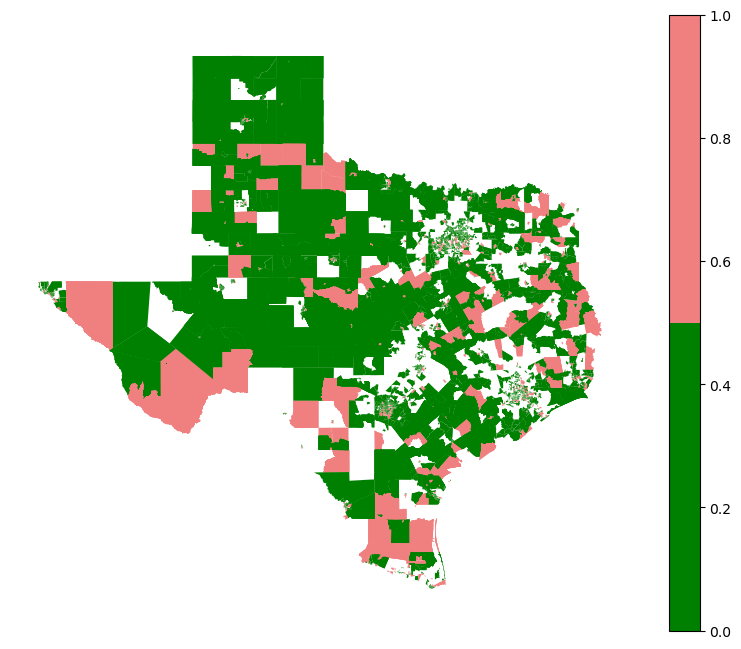

In [18]:
# merge tract polygons with atlas_census_loc
merged_gdf = atlas_census_loc.merge(tracts_gdf, on='GEOID', how='inner')

merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')         # To convert to gdp format
# print(merged_gdf.geometry.head())                                    # it was just to confirm we have geometry for display


fig, ax = plt.subplots(figsize=(10, 8))
cmap = ListedColormap(['green', 'lightcoral'])                         # 0 -> green, 1 -> light red
merged_gdf.plot(column='USDA_flag', cmap=cmap, legend=True, ax=ax)

# exclude axis ticks for a cleaner map
ax.set_axis_off()
plt.show()

In [19]:
snap_active = snap[snap['End Date'].isna() | (snap['End Date'].str.strip() == '')]     # only opened stores
snap_active = snap_active.copy()
strict=['Large Grocery Store','Supermarket','Super Store']                             # USDA definition
enhanced=['Large Grocery Store','Supermarket','Super Store',"Farmers' Market",'Wholesaler']
snap_active['strict'] = snap_active['Store Type'].isin(strict).astype(int)
snap_active['enhanced'] = snap_active['Store Type'].isin(enhanced).astype(int)
snap_active = snap_active[snap_active['strict'] == 1]

snap_active['StateLg'] = snap_active['State'].map(state_mapppings)
snap_active['region'] = snap_active['StateLg'].apply(get_region)
snap_active['selected_states'] = snap_active['State'].apply(get_selected_states)
snap_active['selected_region'] = snap_active['region'].apply(get_selected_region)

print(len(snap_active))
snap_active.sample(4)

42846


,Record ID,Store Name,Store Type,Street Number,Street Name,Additional Address,City,State,Zip Code,Zip4,County,Latitude,Longitude,Authorization Date,End Date,strict,enhanced,StateLg,region,selected_states,selected_region
949027,676739,Food Lion 211,Supermarket,3770,Virginia Beach Blvd,,Virginia Bch,VA,23452,3414,VIRGINIA BEACH,36.84008,-76.10455,11/02/1982,,1,1,Virginia,Southeast,0,1
368008,488117,KROGER 00412,Super Store,4100,Barksdale Blvd,,Bossier City,LA,71112,3900,BOSSIER,32.47847,-93.67641,04/03/1985,,1,1,Louisiana,Southeast,0,1
176810,337747,Walmart 2591,Super Store,151,SW 184th Ave,,Pembroke Pnes,FL,33029,5465,BROWARD,26.00613,-80.39248,09/17/2002,,1,1,Florida,Southeast,0,1
290495,825685,ALDI 62026,Supermarket,10532,S Indianapolis Ave,,Chicago,IL,60617,6355,COOK,41.70379,-87.52575,07/20/2007,,1,1,Illinois,Midwest,0,0


In [20]:
### Adapted from Michael Dunn in stacoverflow:
### https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
### Haversine distance function: input lat/lon ... returns km
import numpy as np
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians.
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km
# process to find the closest store for a given tract row
def find_closest_store(row):
    lat_tract = float(row['INTPTLAT'])
    lon_tract = float(row['INTPTLONG'])
    # estimate vectored distances from this tract to all stores
    dists = haversine(lon_tract, lat_tract, snap_active['Longitude'].values, snap_active['Latitude'].values)
    min_idx = np.argmin(dists)
    return pd.Series({'Closest_Record_ID': snap_active.iloc[min_idx]['Record ID'],'Distance_km': dists[min_idx]
    })
# ensure store coordinates are floats
snap_active['Latitude'] = snap_active['Latitude'].astype(float)
snap_active['Longitude'] = snap_active['Longitude'].astype(float)
merged_gdf.columns = merged_gdf.columns.str.strip()    # INTPTLONG appeard with front spaces from csv. Needed to clean column spaces

merged_gdf[['Closest_Record_ID', 'Distance_km']] = merged_gdf.apply(find_closest_store, axis=1)


## Below cells to be discarted after code cleaning

In [22]:
state_abbrev_to_fips = {'AL': '01', 'AK': '02', 'AZ': '04', 'AR': '05', 'CA': '06', 'CO': '08', 'CT': '09', 'DE': '10', 'DC': '11', 'FL': '12',
                        'GA': '13', 'HI': '15', 'ID': '16', 'IL': '17', 'IN': '18', 'IA': '19', 'KS': '20', 'KY': '21', 'LA': '22', 'ME': '23',
                        'MD': '24', 'MA': '25', 'MI': '26', 'MN': '27', 'MS': '28', 'MO': '29', 'MT': '30', 'NE': '31', 'NV': '32', 'NH': '33', 
                        'NJ': '34', 'NM': '35', 'NY': '36', 'NC': '37', 'ND': '38', 'OH': '39', 'OK': '40', 'OR': '41', 'PA': '42', 'RI': '44', 
                        'SC': '45', 'SD': '46', 'TN': '47', 'TX': '48', 'UT': '49', 'VT': '50', 'VA': '51', 'WA': '53', 'WV': '54', 'WI': '55', 'WY': '56'}


In [23]:

#snap_active = snap_active.drop(columns=['Record ID', 'Additional Address', 'Zip4'])
len(snap_active)
snap_active.groupby('Store Type').size().reset_index(name='counts')
snap_active.groupby('Store Type').size().reset_index(name='counts')

,Store Type,counts
0,Large Grocery Store,3934
1,Super Store,19779
2,Supermarket,19133
